In [4]:
# import the necessary packages
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [17]:
shape_predictor= "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

In [5]:
image_files= glob.glob("images/*.png", )

In [92]:
def calc_landmarks_from_file(image_file,draw=True):
    #read the points file
    points_file= image_file.replace("png", "pts")
    points=np.genfromtxt(points_file,skip_header=3, skip_footer=1, delimiter=' ')
    bbox= np.max(points,axis=0)- np.min(points,axis=0)

    # read the image
    ori_image = cv2.imread(image_file)
    # resize the image to a width of 500 
    image = imutils.resize(ori_image, width=500)
    scale_factor=ori_image.shape[1]/500


    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect all faces in the grayscale image
    rects = detector(gray, 1)
    if len(rects) ==0: # i.e. if no candidates were found
        NaN=float("nan")
        return NaN,(NaN,NaN), ori_image.shape,scale_factor,len(rects)
    # loop over the face detections
    print (f"# BBs: {len(rects)}")
    best_normed_err=10
    
    for (i, rect) in enumerate(rects):
        
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        if True:
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # show the face number
            cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # loop over the (x, y)-coordinates for the facial landmarks
            # and draw them on the image
            for (x, y) in shape:
                cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.show()
        shape= shape *scale_factor
        error = (shape- points)/bbox
        normed_err = np.sqrt(np.mean(np.linalg.norm(error, axis=1)**2))
        if normed_err <best_normed_err:
            best_normed_err = normed_err
            best_shape = shape

            
        
        
    if draw:
        for (x, y) in best_shape:
            cv2.circle(ori_image, (int(x),int(y)), int(2*scale_factor), (0, 0, 255), -1)
        for (x, y) in points:
            cv2.circle(ori_image, (int(x),int(y)), int(2*scale_factor), (0, 255, 0), -1)
        plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
        plt.show()
    
    return best_normed_err,bbox, ori_image.shape,scale_factor, len(rects)




In [6]:
def getBoundingBox(image_file,draw=True):
    
    points_file= image_file.replace("png", "pts")
    #points=np.genfromtxt(points_file, delimiter=' ')
    points=np.genfromtxt(points_file,skip_header=3, skip_footer=1, delimiter=' ')
    
    ori_image = cv2.imread(image_file)
    # resize the image to a width of 500 
    image = imutils.resize(ori_image, width=500)
    scale_factor=ori_image.shape[1]/500
    '''
    #Get bounding box coordinates, width and height
    x, y = np.min(points, axis =0)
    w, h = np.max(points, axis =0)
    if (x >= 20):
        x -= 20
    if (y >= 20):
        y -= 20
    w = w-x+20
    h = h-y+20
    '''
    
    #Compute the BB
    x, y = np.min(points, axis =0)
    maxX, maxY = np.max(points, axis =0)
    
    w = maxX - x
    h = maxY - y
    
    #Leave more space around the landmarks
    if(x>=10):
        x-=10
        w+=20
    else:
        w+=10
    if(y>=10):
        y-=10
        h+=20
    else:
        y+=10
    
    if(w>h):
        if(y>=((w-h)/2)):
            y-=(w-h)/2
        h = w
    
    else:
        if(x>=((h-w)/2)):
            x-=(h-w)/2
        w = h
        
    if((int(y+h)-int(y)) < (int(x+w)-int(x))):
        h+=1
    elif((int(y+h)-int(y)) > (int(x+w)-int(x))):
        w+=1
    
    #Save cropped image around BB
    bb_file= image_file.replace("images", "bbimages")
    bb_file= bb_file.replace(".png", "BB.png")
    roi = ori_image[int(y):int(y+h), int(x):int(x+w)]
    #cv2.imwrite(bb_file, roi)
    
    #Modify landmark values and save them
    bb_p_file= bb_file.replace("png", "pts")
    points_bb = points - np.array([x,y])
    points_bb = np.around(points_bb, decimals=3)

    #np.savetxt(bb_p_file, points_bb, fmt='%1.3f', delimiter=' ')

    if(draw):
    
        cv2.rectangle(ori_image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    
        for (x, y) in points:
            cv2.circle(ori_image, (int(x),int(y)), int(2*scale_factor), (0, 255, 0), -1)

        plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
        plt.show()

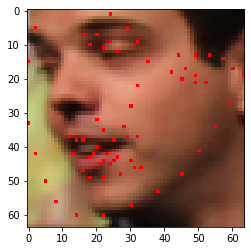

0.2226968811189504

In [9]:
def NME(pred, true, w, h):
    
    d = np.sqrt(w*h)
    NME = np.sum(np.sqrt(torch.sum(np.square(true-pred), axis = 1))/d)/68
    
    return NME

def detectLandmarks(image_file,draw=True):
    #read the points file
    points_file= image_file.replace("png", "pts")
    points=np.genfromtxt(points_file, delimiter=' ')

    # read the image
    ori_image = cv2.imread(image_file)

    gray = cv2.cvtColor(ori_image, cv2.COLOR_BGR2GRAY)
    
    height, width, channels = ori_image.shape
    
    left = 0
    top = 0
    right = width
    bottom = height

    rect = dlib.rectangle(left, top, right, bottom)
    
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    
    if draw:
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(ori_image, (x, y), 0, (0, 0, 255), -1)
        plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
        plt.show()
    
    return NME(shape, points, width, height)


detectLandmarks(image_files[155])

In [13]:
def resizeTo224(image_file):
    
    points_file= image_file.replace("png", "pts")

    points=np.genfromtxt(points_file, delimiter=' ')
    ori_image = cv2.imread(image_file)
    height, width, channels = ori_image.shape
    # resize image
    dim = (224, 224)
    resized = cv2.resize(ori_image, dim, interpolation = cv2.INTER_AREA)
    
    #Save resized image
    bb_file= image_file.replace("bbimages", "bbimages224")
    bb_file= bb_file.replace("BB.png", ".png")
    cv2.imwrite(bb_file, resized)

    #Modify landmark values and save them
    bb_p_file= bb_file.replace("png", "pts")
    points_bb = points / (height/224)
    points_bb = np.around(points_bb, decimals=3)
    np.savetxt(bb_p_file, points_bb, fmt='%1.3f', delimiter=' ')

In [102]:
def resizeTo64(image_file):
    
    points_file= image_file.replace("png", "pts")

    points=np.genfromtxt(points_file, delimiter=' ')
    ori_image = cv2.imread(image_file)
    height, width, channels = ori_image.shape
    # resize image
    dim = (64, 64)
    resized = cv2.resize(ori_image, dim, interpolation = cv2.INTER_AREA)
    
    #Save resized image
    bb_file= image_file.replace("bbimages", "bbimages64")
    bb_file= bb_file.replace("BB.png", ".png")
    cv2.imwrite(bb_file, resized)

    #Modify landmark values and save them
    bb_p_file= bb_file.replace("png", "pts")
    points_bb = points / (height/64)
    points_bb = np.around(points_bb, decimals=3)
    np.savetxt(bb_p_file, points_bb, fmt='%1.3f', delimiter=' ')

In [14]:
image_files_to_resize=image_files

for image_file in image_files_to_resize:
    resizeTo224(image_file)


In [20]:
def printPoints(image_file, original = False):
    
    points_file= image_file.replace("png", "pts")

    if(original):
        points=np.genfromtxt(points_file,skip_header=3, skip_footer=1, delimiter=' ')
    else:
        points=np.genfromtxt(points_file, delimiter=' ')
    
    ori_image = cv2.imread(image_file)
    z = np.zeros((64,64))
    for (x, y) in points:
        cv2.circle(ori_image, (int(x),int(y)), 0, (0, 255, 0), -1)
        z+=generateHeatmap(int(y),int(x),False)
    
    v = plt.imshow(z, cmap='hot', interpolation='nearest')
    plt.show()
    plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    plt.show()

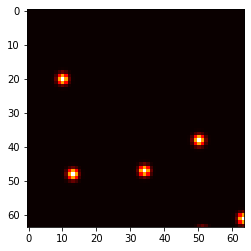

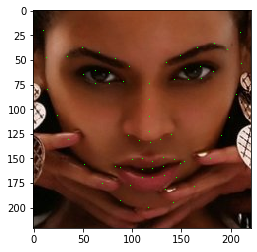

bbimages\indoor_001BB.png


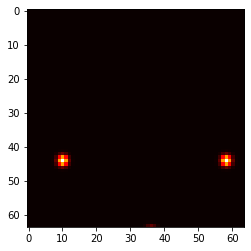

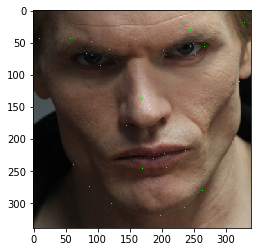

bbimages\indoor_002BB.png


In [21]:
image_files_to_show=image_files[0:2]

for image_file in image_files_to_show:
    printPoints(image_file,False)
    print(image_file)

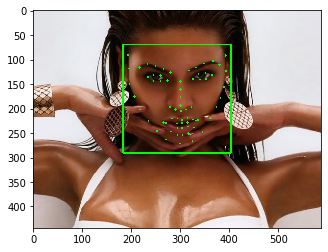

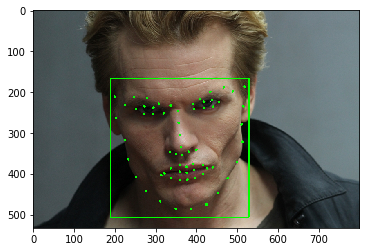

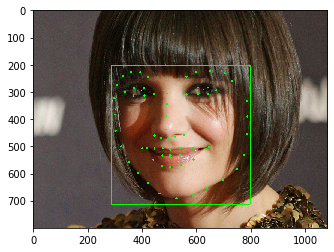

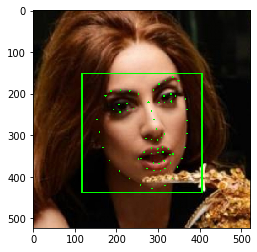

In [8]:
# this is where you select a subset of the files
image_files_to_explore=image_files[0:4]
# show  each picture?
draw =True

for image_file in image_files_to_explore:
    getBoundingBox(image_file,draw)

# BBs: 1


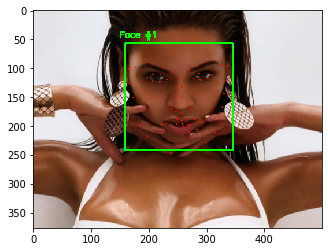

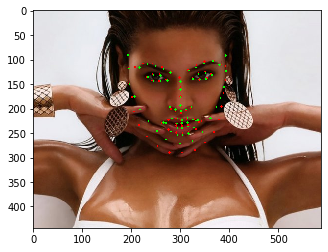

# BBs: 1


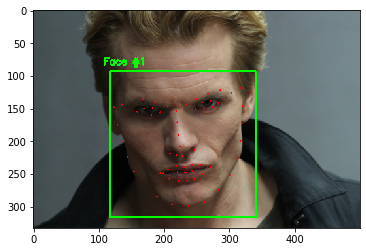

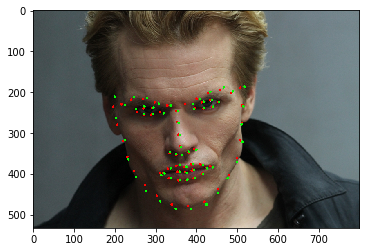

# BBs: 1


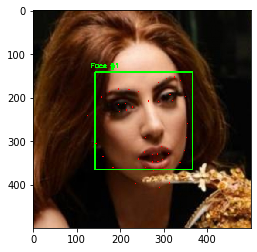

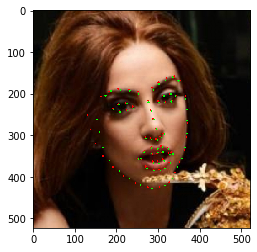

# BBs: 1


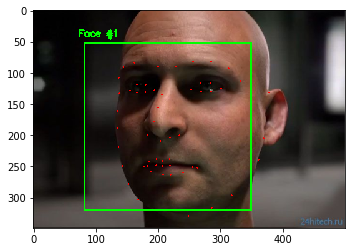

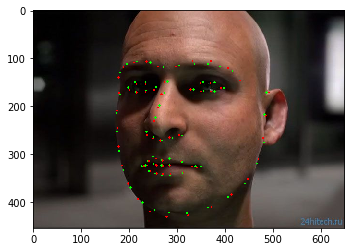

# BBs: 1


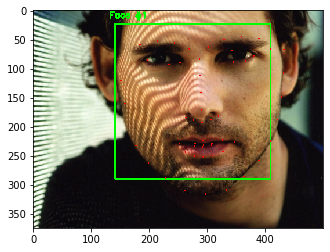

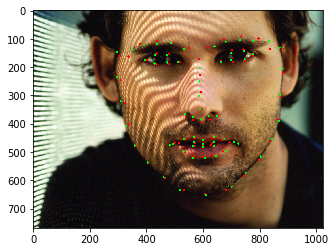

# BBs: 1


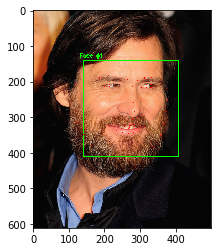

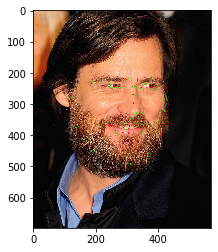

# BBs: 1


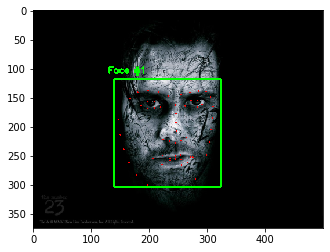

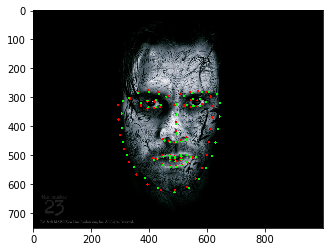

# BBs: 1


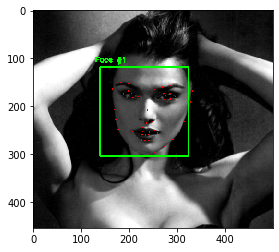

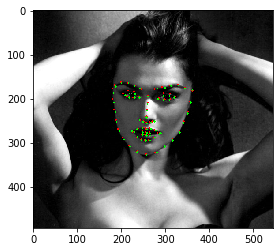

# BBs: 1


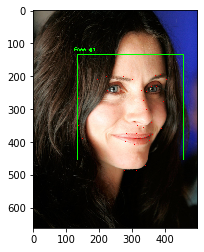

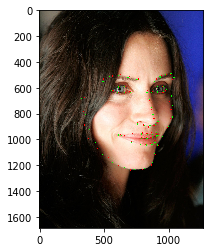

# BBs: 1


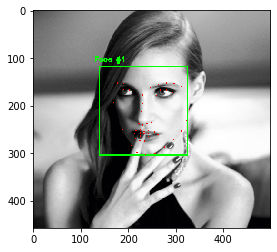

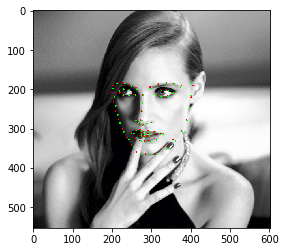

,FileName,Height,Width,BBox_W,BBox_H,Scale,Detected Faces,Normed_Err
0,images\indoor_001.png,444,588,201.302,180.435,1.176,1,0.072648
1,images\indoor_002.png,533,800,318.827,299.723,1.600,1,0.026742
2,images\indoor_003.png,800,1082,NaN,NaN,2.164,0,NaN
3,images\indoor_004.png,523,522,215.869,267.394,1.044,1,0.034709
4,images\indoor_005.png,454,650,312.588,315.651,1.300,1,0.024085
5,images\indoor_006.png,768,1024,586.170,544.141,2.048,1,0.023062
6,images\indoor_007.png,697,570,302.965,282.340,1.140,1,0.033074
7,images\indoor_008.png,750,1000,340.437,345.364,2.000,1,0.036089
8,images\indoor_009.png,494,544,179.901,162.717,1.088,1,0.023891
9,images\indoor_010.png,1685,1271,712.061,746.684,2.542,1,0.028241


In [46]:
# This is w
df=pd.DataFrame(columns= ['FileName','Height','Width','BBox_W','BBox_H','Scale','Detected Faces','Normed_Err'])
for image_file in image_files_to_explore:
    normed_err, bbox, size,scale_factor,detected_faces = calc_landmarks_from_file(image_file, draw=draw)
    res={}
    res['FileName']=image_file
    res['Height']=size[0]
    res['Width']=size[1]    
    res['BBox_W']=bbox[0]
    res['BBox_H']=bbox[1]
    res['Scale']=scale_factor    
    res['Detected Faces']=detected_faces
    res['Normed_Err']=normed_err   
    
    df= df.append(res, ignore_index=True)
df

In [43]:
df.to_excel("baseline_test_results.xlsx")    
df

,FileName,Height,Width,BBox_W,BBox_H,Scale,Detected Faces,Normed_Err
0,images\indoor_001.png,444,588,201.302,180.435,1.176,1,0.072648
1,images\indoor_002.png,533,800,318.827,299.723,1.600,1,0.026742
2,images\indoor_003.png,800,1082,NaN,NaN,2.164,0,NaN
3,images\indoor_004.png,523,522,215.869,267.394,1.044,1,0.034709
4,images\indoor_005.png,454,650,312.588,315.651,1.300,1,0.024085
5,images\indoor_006.png,768,1024,586.170,544.141,2.048,1,0.023062
6,images\indoor_007.png,697,570,302.965,282.340,1.140,1,0.033074
7,images\indoor_008.png,750,1000,340.437,345.364,2.000,1,0.036089
8,images\indoor_009.png,494,544,179.901,162.717,1.088,1,0.023891
9,images\indoor_010.png,1685,1271,712.061,746.684,2.542,1,0.028241


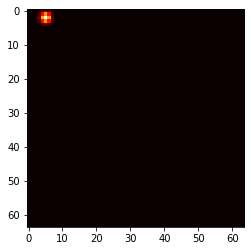

array([[8.02694235e-08, 7.22562324e-06, 2.39279779e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.59742598e-07, 3.23829967e-05, 1.07237757e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.93115274e-07, 5.33905355e-05, 1.76805171e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [19]:
def bivariateGaussianProb(x,y, meanX, meanY):
    
    cov = np.eye(2)
    x = np.array([x,y])
    #x = xT.reshape((2,1))
    mean = np.array([meanX,meanY])
    
    diff = x-mean
    
    const = 1/(np.sqrt(np.square(2*np.pi)*np.linalg.det(cov)))
    
    exp = np.exp((-1/2)*np.dot(np.dot(diff,np.linalg.inv(cov)),diff.reshape((2,1))))
    
    return const*exp
    
#Generate heatmap for keypoint (x,y)
def generateHeatmap(x,y, draw=False):
    
    z = np.zeros((64,64))
    for i in range(64):
        for j in range(64):
            z[i][j] = bivariateGaussianProb(i,j, x, y)
    
    if(draw):
        plt.imshow(z, cmap='hot', interpolation='nearest')
        plt.show()
        
    return z
    
generateHeatmap(2,5,True)